# 日経平均株価 週足 メディアン統計

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [3]:
code = 'N225'
symbol = '^%s' % code
ticker = yf.Ticker(symbol)

In [4]:
# 週足で過去 5 年分のデータを取得
df0 = ticker.history(period='10y', interval='1wk')

# ローソク足のチャートには、そのうち過去 3 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_3y =  datetime.timedelta(days=365 * 3)
df = df0[df0.index >= dt_last - tdelta_3y]

## Moving Median

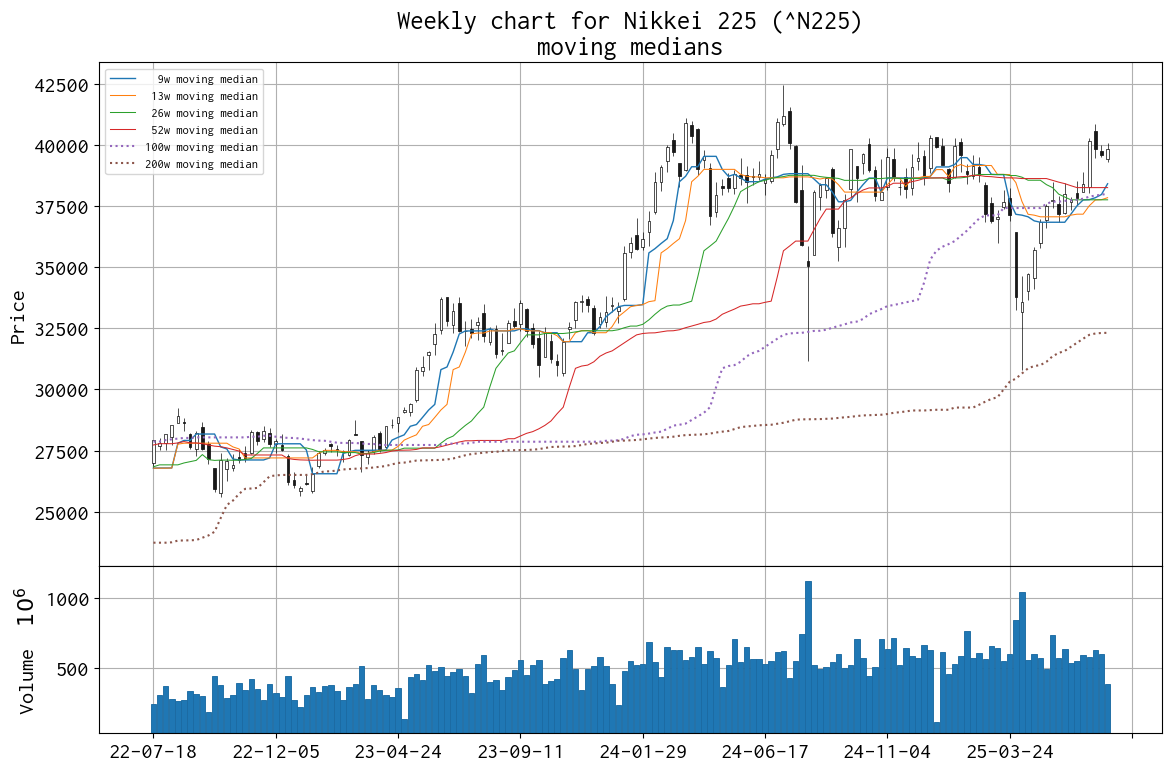

In [5]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

mm09 = df0["Close"].rolling(9).median()
mm13 = df0["Close"].rolling(13).median()
mm26 = df0["Close"].rolling(26).median()
mm52 = df0["Close"].rolling(52).median()
mm100 = df0["Close"].rolling(100).median()
mm200 = df0["Close"].rolling(200).median()

apds = [
    mpf.make_addplot(mm09[df.index], width=1, label="  9w moving median", ax=ax[0]),
    mpf.make_addplot(mm13[df.index], width=0.75, label=" 13w moving median", ax=ax[0]),
    mpf.make_addplot(mm26[df.index], width=0.75, label=" 26w moving median", ax=ax[0]),
    mpf.make_addplot(mm52[df.index], width=0.75, label=" 52w moving median", ax=ax[0]),
    mpf.make_addplot(
        mm100[df.index],
        width=1.5,
        linestyle="dotted",
        label="100w moving median",
        ax=ax[0],
    ),
    mpf.make_addplot(
        mm200[df.index],
        width=1.5,
        linestyle="dotted",
        label="200w moving median",
        ax=ax[0],
    ),
]

mpf.plot(
    df,
    type="candle",
    style="default",
    volume=ax[1],
    datetime_format="%y-%m-%d",
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)

ax[0].set_title(
    "Weekly chart for %s (%s)\nmoving medians" % (ticker.info["longName"], symbol)
)
ax[0].legend(loc="upper left", fontsize=9)

plt.tight_layout()
plt.savefig("report_weekly_chart_median_%s.png" % code)
plt.show()

In [6]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-07-07 00:00:00+09:00,39729.558594,39971.058594,39497.699219,39569.679688,604200000,0.0,0.0
2025-07-14 00:00:00+09:00,39416.101562,40087.589844,39288.898438,39819.109375,388200000,0.0,0.0


In [7]:
df.tail(2)['Close']

Date
2025-07-07 00:00:00+09:00    39569.679688
2025-07-14 00:00:00+09:00    39819.109375
Name: Close, dtype: float64

In [8]:
df.tail(2)['Close'].diff()

Date
2025-07-07 00:00:00+09:00           NaN
2025-07-14 00:00:00+09:00    249.429688
Name: Close, dtype: float64

In [9]:
df['Close'].rolling(9).median().tail(10)

Date
2025-05-12 00:00:00+09:00    36830.691406
2025-05-19 00:00:00+09:00    36830.691406
2025-05-26 00:00:00+09:00    36830.691406
2025-06-02 00:00:00+09:00    37160.468750
2025-06-09 00:00:00+09:00    37503.328125
2025-06-16 00:00:00+09:00    37741.609375
2025-06-23 00:00:00+09:00    37753.718750
2025-06-30 00:00:00+09:00    37834.250000
2025-07-07 00:00:00+09:00    37965.101562
2025-07-14 00:00:00+09:00    38403.230469
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail(10)

Date
2025-05-12 00:00:00+09:00    37053.101562
2025-05-19 00:00:00+09:00    37053.101562
2025-05-26 00:00:00+09:00    37053.101562
2025-06-02 00:00:00+09:00    37120.328125
2025-06-09 00:00:00+09:00    37160.468750
2025-06-16 00:00:00+09:00    37160.468750
2025-06-23 00:00:00+09:00    37503.328125
2025-06-30 00:00:00+09:00    37741.609375
2025-07-07 00:00:00+09:00    37753.718750
2025-07-14 00:00:00+09:00    37834.250000
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail(10)

Date
2025-05-12 00:00:00+09:00    38245.941406
2025-05-19 00:00:00+09:00    37980.875000
2025-05-26 00:00:00+09:00    37859.410156
2025-06-02 00:00:00+09:00    37747.664062
2025-06-09 00:00:00+09:00    37747.664062
2025-06-16 00:00:00+09:00    37747.664062
2025-06-23 00:00:00+09:00    37747.664062
2025-06-30 00:00:00+09:00    37747.664062
2025-07-07 00:00:00+09:00    37747.664062
2025-07-14 00:00:00+09:00    37747.664062
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail(10)

Date
2025-05-12 00:00:00+09:00    38542.183594
2025-05-19 00:00:00+09:00    38469.679688
2025-05-26 00:00:00+09:00    38407.865234
2025-06-02 00:00:00+09:00    38324.060547
2025-06-09 00:00:00+09:00    38245.941406
2025-06-16 00:00:00+09:00    38245.941406
2025-06-23 00:00:00+09:00    38245.941406
2025-06-30 00:00:00+09:00    38245.941406
2025-07-07 00:00:00+09:00    38245.941406
2025-07-14 00:00:00+09:00    38245.941406
Name: Close, dtype: float64

In [13]:
df0['Close'].rolling(100).median().tail(10)

Date
2025-05-12 00:00:00+09:00    37672.234375
2025-05-19 00:00:00+09:00    37672.234375
2025-05-26 00:00:00+09:00    37700.484375
2025-06-02 00:00:00+09:00    37732.759766
2025-06-09 00:00:00+09:00    37747.664062
2025-06-16 00:00:00+09:00    37793.984375
2025-06-23 00:00:00+09:00    37874.085938
2025-06-30 00:00:00+09:00    37924.341797
2025-07-07 00:00:00+09:00    37949.931641
2025-07-14 00:00:00+09:00    38009.386719
Name: Close, dtype: float64

In [14]:
df0['Close'].rolling(200).median().tail(5)

Date
2025-06-16 00:00:00+09:00    32071.320312
2025-06-23 00:00:00+09:00    32228.959961
2025-06-30 00:00:00+09:00    32284.709961
2025-07-07 00:00:00+09:00    32306.054688
2025-07-14 00:00:00+09:00    32311.924805
Name: Close, dtype: float64

## Robust Bollinger bands

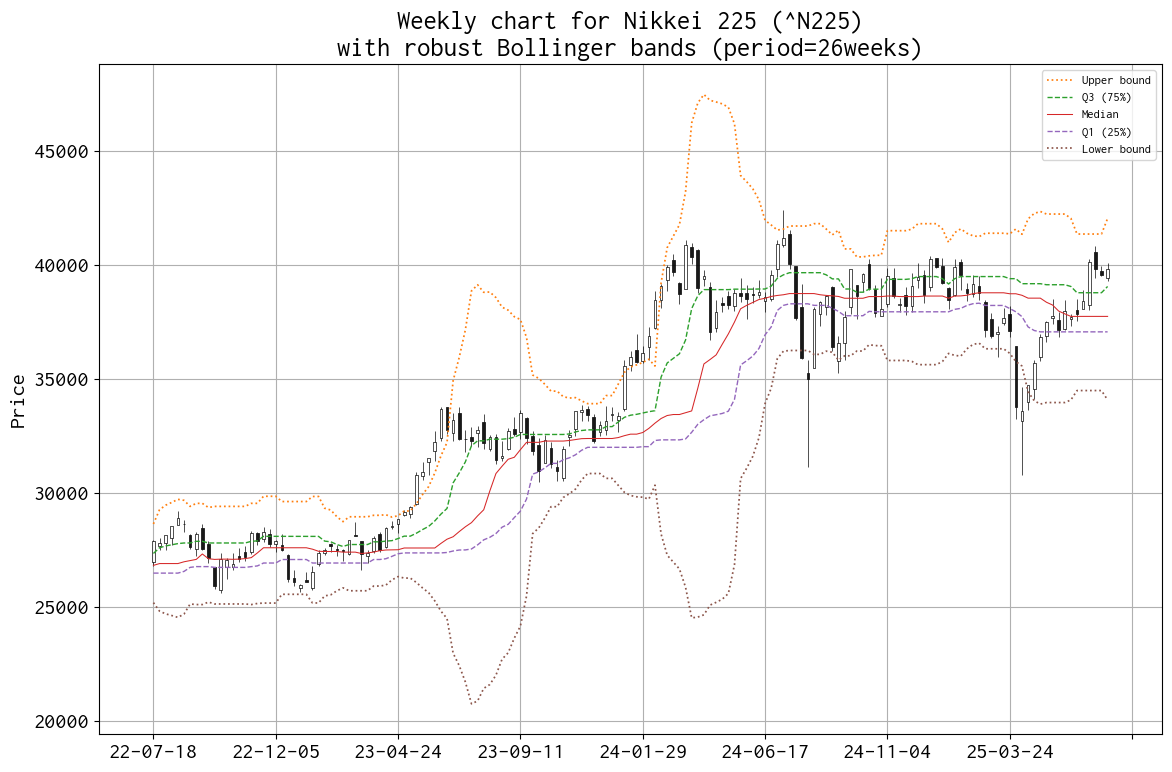

In [15]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 26
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Weekly chart for %s (%s)\nwith robust Bollinger bands (period=%dweeks)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Weekly chart for %s\nwith robust Bollinger bands (period=%sweeks)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_weekly_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラムと Q-Q プロット

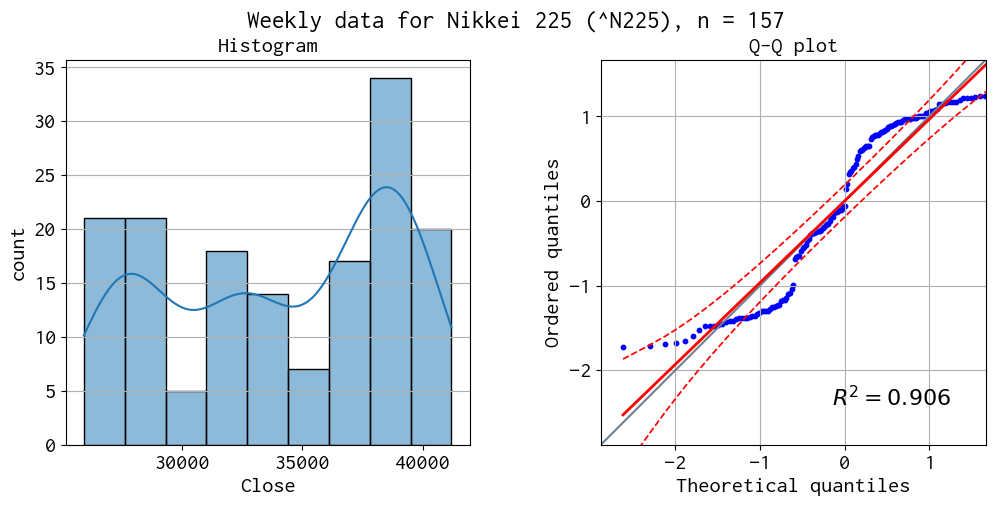

In [16]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Weekly data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_weekly_histogram_qqplot_%s.png' % code)
plt.show()